# Macrostrat: North American Continental Sedimentation

### Adrian Tasistro-Hart

This notebook investigates the patterns of sedimentation within three basic subdivisions of North America to decompose the continental time series presented by Peters and Husson into the signals from the constituent basins.

The subdivisions are shown below in the section that defines the geometry of the three areas.

In [473]:
# basic
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import pandas as pd

# GIS
import geopandas as gpd
import cartopy.crs as ccrs

# other
from tqdm import tqdm_notebook
import ipywidgets as widgets

%matplotlib inline

# styling
plt.style.use('seaborn-talk')

In [2]:
api_url_base = 'https://macrostrat.org/api/'

## Download data

The following code blocks download the necessary Macrostrat column and unit data to generate geojson files columns.json, units.json, and units_seds.json. These data are also then saved as shapefiles, since these load much more quickly than the json files.

### Download columns

In [41]:
# download all columns
response = requests.get(api_url_base + 'columns?all&format=geojson_bare&response=long')
columns_json = json.loads(response.content.decode('utf-8'))
# save to geojson file
with open('data/columns.json', 'w') as outfile:
    json.dump(columns_json, outfile)
    
# reopen and save to shapefile (much faster to deal with)
columns = gpd.read_file('data/columns.json')
columns.to_file('data/columns.shp')

### Download units

In addition to downloading all units hosted by Macrostrat, we'll also consider extract units that are only sedimentary.

In [42]:
# now get all units
response = requests.get(api_url_base + 'units?all&format=geojson_bare&response=long')
units_json = json.loads(response.content.decode('utf-8'))
# save to geojson file
with open('data/units.json', 'w') as outfile:
    json.dump(units_json, outfile)
    
# reopen and save to shapefile (much faster to deal with)
units = gpd.read_file('data/units.json')
units.to_file('data/units.shp')

In [43]:
# now get all sedimentary units
response = requests.get(api_url_base + 'units?lith_class=sedimentary&format=geojson_bare&response=long')
units_seds_json = json.loads(response.content.decode('utf-8'))
# save to geojson file
with open('data/units_seds.json', 'w') as outfile:
    json.dump(units_seds_json, outfile)
    
# reopen and save to shapefile (much faster to deal with)
units_seds = gpd.read_file('data/units_seds.json')
units_seds.to_file('data/units_seds.shp')

## Load and preprocess

### Macrostrat data

Having downloaded the data, the following code blocks load in the geojson files into geodataframes and isolate the North American (project id = 1) columns and units. I also project the coordinates into a Lambert Conformal Conic projection centered on Michigan for better visualization.

In [46]:
# load columns and units
columns = gpd.read_file('data/columns.shp')
units = gpd.read_file('data/units.shp')
units_seds = gpd.read_file('data/units_seds.shp')

# change index on columns
columns.set_index(columns['col_id'], inplace=True)

In [47]:
# choose North American Lambert projection
epsg = 2252
proj4 = {'init': 'epsg:%d' % epsg}

# project columns and units
columns = columns.to_crs(proj4)
units = units.to_crs(proj4)
units_seds = units_seds.to_crs(proj4)

Here I extract the North American units and columns and provide a basic visualization of both, with columns colored by group_id, which is the basic grouping of columns based on their source material.

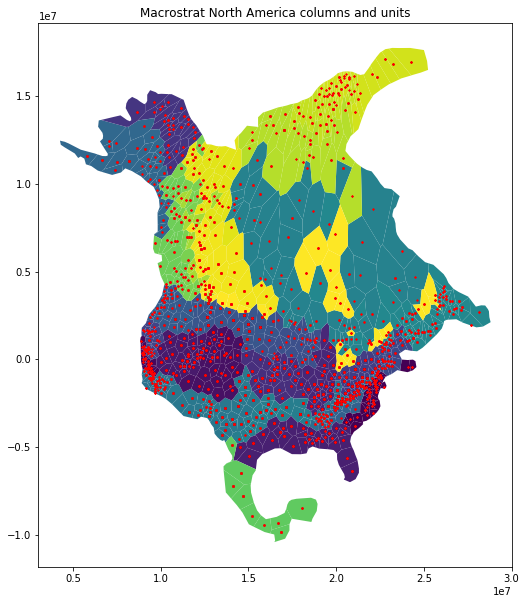

In [52]:
# let's focus just on north america
columns_na = columns[columns['project_id']==1]
units_na = units[units['project_id']==1]
units_seds_na = units_seds[units_seds['project_id']==1]

# plot units on columns
ax = columns_na.plot(column='col_group_', figsize=(10,10))
units_na.plot(ax=ax, marker='.', markersize=2, color='r')
plt.title('Macrostrat North America columns and units')
plt.show()

In [67]:
# some useful quantities
n_sed_units = len(units_seds)
n_sed_units_na = len(units_seds_na)
n_cols = len(columns_na)
n_cols_seds = len(units_seds_na['col_id'].unique())

### Other datasets

Let's also load other datasets like sealevel curves and the Ronov 1994 data.

In [419]:
sea_level = pd.read_excel('data/Globalsealevelrecords_miller.xls')

## Geospatial visualization of sedimentation through time
The following section provides visualizations through time of the geospatial extent of accumulated sediment thickness to provide intuition for where and what kind of sedimentation occurs. These visualizations help motivate the subsequent subdivision of North America into basic sedimentary domains.

The first visualization provides an interactive set of sliders that allow the user to specify age ranges and display total accumulated sediments by column for each age range.

### Column preprocessing

Generating these visualizations must account for a few peculiarities of the Macrostrat data structure. The first is that units are bounded only by top and bottom ages, meaning that at best, only average (i.e. constant) sedimentation rates per unit can be computed. Furthermore, given that only maximum and minimum unit thicknesses are provided, only upper and lower bounds on average sedimentation rate and total accumulation can be computed. Finally, units can overlap within a column, which means that total accumulated sediment thickness could easily be overestimated by double-counting coeval sediments within a column.

The following code snippets compute typical unit durations and show the relationship between unit thicknesses and durations for the units whose deposition lasts longer than 100 My. I then discuss models for computing maximum and minimum sediment accumulation thicknesses, outlining a simple approach that tries to mitigate double-counting when units overlap and when units straddle time bounds of interest.

In [68]:
# depositional durations for each sedimentary unit
t_ranges = units_seds_na['b_age'] - units_seds_na['t_age']

# sed rates
sedrate_max = units_seds_na['max_thick']/t_ranges
sedrate_min = units_seds_na['min_thick']/t_ranges
# ignore zeros
idx_max = sedrate_max != 0
idx_min = sedrate_min != 0

max_dur = 100
long_units = t_ranges > max_dur
long_unit_cols = units_seds_na[long_units]['col_id'].unique()
long_columns = columns_na['col_id'].isin(long_unit_cols)

print('Median unit duration: %1.2f My\nMean unit duration: %1.2f My\n%1.2f%% of units longer than %d My' % (np.median(t_ranges), np.mean(t_ranges), np.sum(long_units)/len(units_na)*100, max_dur))

Median unit duration: 3.12 My
Mean unit duration: 8.68 My
0.78% of units longer than 100 My


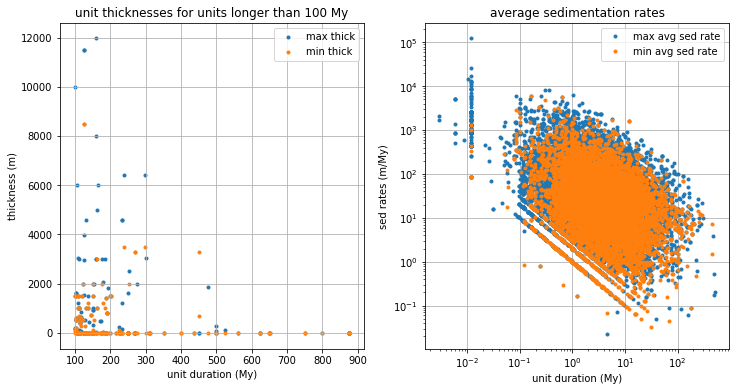

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# plot thicknesses for long units
ax[0].scatter(t_ranges[long_units], units_seds_na[long_units]['max_thick'], marker='.', label='max thick')
ax[0].scatter(t_ranges[long_units], units_seds_na[long_units]['min_thick'], marker='.', label='min thick')
ax[0].set_xlabel('unit duration (My)')
ax[0].set_ylabel('thickness (m)')
ax[0].set_title('unit thicknesses for units longer than 100 My')
ax[0].legend()
ax[0].grid()

# plot average sedimentation rates vs unit duration
ax[1].loglog(t_ranges[idx_max], sedrate_max[idx_max], '.', label='max avg sed rate')
ax[1].loglog(t_ranges[idx_min], sedrate_min[idx_min], '.', label='min avg sed rate')
ax[1].set_xlabel('unit duration (My)')
ax[1].set_ylabel('sed rates (m/My)')
ax[1].set_title('average sedimentation rates')
ax[1].legend()
ax[1].grid()

plt.show()

#### Units straddling time bounds

Given that units can and will straddle the boundary for a user-selected time interval, I propose the following scheme for accounting for units extending beyond these boundaries. Firstly, all sedimentation within units will be assumed to occur at a constant rate. Thus, the fraction of its total duration that a unit either succeeds the upper boundary or precedes the lower boundary (or both) is also the fraction of its accumulated thickness that is assumed not to have deposited within the chosen time interval. 

The following equations implement this model, where a weighting factor is computed that reflects the portion of the unit's thickness that is assumed to occur within the user-selected time bounds.

\begin{align} 
w &= \max\left(0, \frac{x}{d}\right) \\
x &= d - a - b \\
a &= \max\left(0, t^u_i-t^b_i \right) \\
b &= \max\left(0, t_f^b-t^u_f \right)
\end{align}

where the variables $t^u_i$, $t^b_i$ refer to the lower time bounds on the unit and time bin of interest, respectively, and $t_f^b$, $t^u_f$ refer to the upper time bounds on the time bin and unit, respectively. The following code block implements this correction.

In [124]:
# compute overlap weights for each unit and the given time bin
def bin_overlap_correction(units, t1, t2):
    d = units['b_age'].values - units['t_age'].values
    a = np.vstack((np.zeros((len(units))), 
                   units['b_age'].values - t1)).T
    a = np.max(a, axis=1)
    b = np.vstack((np.zeros((len(units))), 
                   t2 - units['t_age'].values)).T
    b = np.max(b, axis=1)
    w = (d - a - b)/d
    w[w < 0] = 0
    return w

#### Coeval units within columns

The next consideration is that units sometimes overlap temporally within columns. The vertical spatial height corresponding to the temporal overlap will be in general different for each of the units, given that they have different average sedimentation rates. When computing a maximum thickness estimate then, it would be desirable to remove the overlap corresponding to the more slowly accumulating units, leaving only the height corresponding to the fastest accumulating unit. When computing minimum thickness estimates, it would be desirable instead to take the thickness corresponding to the slowest accumulating unit over the duration of unit overlap.

Given that multiple units can overlap with each other, it is necessary to isolate each unique temporal interval of unit overlap, i.e. identifying the intervals where various units overlap with each other. For each of these intervals where $n$ units overlap, the unit thicknesses corresponding to the units with the $n-1$ minimum/maximum sedimentation rates are removed for the maximum/minimum sediment accumulation estimates, respectively. 

The following fairly lengthy code block implements this correction, and the algorithm outline is presented in [this document]('notes/Macrostrat_doublecount_correction.pdf').

In [125]:
# idx_groups: dictionary with col_ids and indices of units corresponding to each column
# units: dataframe indexed by idx_groups into columns
#
# generate thickness corrections to subtract from the thicknesses naively computed in seds_by_column_and_age
# correction are then positive
def unit_overlap_correction(idx_groups, units_in):
    cols = idx_groups.keys()
    # create dataframe of corrections (default zero correction)
    corr = pd.DataFrame(index=cols, columns=['max_corr', 'min_corr'])
    corr[:] = 0
    # loop over columns (might be faster with smart groupby() call)
    for col in cols:
        # units in column
        col_units = units_in.iloc[idx_groups.get(col)][['t_age', 'b_age', 'max_thick', 'min_thick']]
        # loop over units 
        n_units = len(col_units)
        ovlap_coords = []
        ovlap_units = []
        # find overlapping units
        for ii in range(n_units):
            for jj in range(ii+1, n_units):
                ti_t, ti_b = col_units.iloc[ii]['t_age'], col_units.iloc[ii]['b_age']
                tj_t, tj_b = col_units.iloc[jj]['t_age'], col_units.iloc[jj]['b_age']
                if (ti_b >= tj_t) & (tj_b >= ti_t):
                    ovlap_coords.append([np.max([ti_t, tj_t]), np.min([ti_b, tj_b])])
                    ovlap_units.append([ii,jj])
        # check if any units overlap, if not, return zero
        if len(ovlap_coords) == 0:
            continue
        
        # get average (max) sedimentation rate for each unit
        avg_sed_rates_max = col_units['max_thick']/(col_units['b_age']-col_units['t_age'])
        avg_sed_rates_min = col_units['min_thick']/(col_units['b_age']-col_units['t_age'])
        
        # having found overlapping units, (at II 1), pg. 4 ), find unique coordinates of overlapping segments
        unique_coords = np.unique(np.asarray(ovlap_coords))
        # create list with overlap vertices as indices
        ovlaps_verts_units = np.empty(len(unique_coords), dtype=object)
        for ii in range(len(unique_coords)):
            ovlaps_verts_units[ii] = [np.nan] * 1
        for coords, units in zip(ovlap_coords, ovlap_units):
            idx_coords = (unique_coords >= coords[0]) & (unique_coords <= coords[1])
            cur_ovlaps = ovlaps_verts_units[idx_coords]
            for ii in range(len(cur_ovlaps)):
                cur_ovlaps[ii] = cur_ovlaps[ii] + units
            ovlaps_verts_units[idx_coords] = cur_ovlaps
        for ii in range(len(ovlaps_verts_units)):
            # get unique unit indices
            ovlaps_verts_units[ii] = np.unique(np.asarray(ovlaps_verts_units[ii]))
            # get rid of nans
            not_na_idx = np.logical_not(np.isnan(ovlaps_verts_units[ii]))
            ovlaps_verts_units[ii] = ovlaps_verts_units[ii][not_na_idx]
            
        # now with array with overlapping vertices denoted by overlapping unit indices at each vertex, create
        # vector with entries denoting segments, not endpoints (pg.3 figure at bottom)
        n_ovlap_segs = len(unique_coords)-1
        ovlap_segs_units = np.empty(n_ovlap_segs, dtype=object)
        ovlap_segs_wids = np.zeros(n_ovlap_segs)
        for ii in range(n_ovlap_segs):
            ovlap_segs_units[ii] = list(set(ovlaps_verts_units[ii+1]) & set(ovlaps_verts_units[ii]))
            ovlap_segs_wids[ii] = unique_coords[ii+1] - unique_coords[ii]
        
        # subtract thinnest units of the overlapping ones (i.e. n-1 slowest avg sed rates times overlap width)
        # loop over vertices
        for ii in range(n_ovlap_segs):
            # get units in current overlapping segment
            cur_units = ovlap_segs_units[ii]
            # for each unit, get thicknesses (sed rates x durations)
            ovlap_thicks_max = np.sort(avg_sed_rates_max.iloc[cur_units].values * ovlap_segs_wids[ii])
            ovlap_thicks_min = np.sort(avg_sed_rates_min.iloc[cur_units].values * ovlap_segs_wids[ii])
            # take sum of smallest/largest thicknesses as maximum/minimum corrections
            corr.loc[col, 'max_corr'] = corr.loc[col, 'max_corr'] + np.sum(ovlap_thicks_max[0:-1])
            corr.loc[col, 'min_corr'] = corr.loc[col, 'min_corr'] + np.sum(ovlap_thicks_min[1:])
            
    return corr

The following function *seds_by_column_and_age_range()* then implements the column-wise sedimentary thickness computation within user-provided time bounds.

In [526]:
# t[1] > t[0]
# method='thickness' (default), 'presence' : whether to estimate columnwise thicknesses or just presence/absence a la Peters/Husson. 
# returns:
#  tmp_df: dataframe indexed by col_id with column geometry. if method='presence', then the singular data column is boolean indicating presence of sediments within the requested time interval. if method='thickness', then two data columns are returned containing the maximum and minimum estimated accumulations of sediment within the requested time interval
def seds_by_column_and_age_range(units, t1, t2, method='thickness'):
    assert t1 > t2, 't1 must be larger than t2'
    assert method in ['thickness', 'presence'], 'invalid value for method' 
    # copy data so we don't mess with originals
    units = units.copy()
    columns_na_tmp = columns_na.copy()
    columns_na_tmp.index = columns_na_tmp['col_id']
    
    # correct for units that span beyond t1 or t2
    w = bin_overlap_correction(units, t1, t2)
    # indices of units within time bounds
    idx_units_in_bounds = w != 0
    # if just looking for presence, then this is enough
    if method=='presence':
        tmp_df = columns_na_tmp[['geometry']].copy()
        units['presence'] = idx_units_in_bounds.astype(int)
        tmp_df['presence'] = units.groupby(['col_id']).sum()['presence']
        tmp_df.loc[tmp_df['presence'] > 0, 'presence'] = 1
        return tmp_df
    elif method=='thickness':
        # get just these units
        w = w[idx_units_in_bounds]
        units = units[idx_units_in_bounds]
        # apply weights
        max_thicks = w * units['max_thick'] 
        min_thicks = w * units['min_thick']
        units['max_thick'] = max_thicks
        units['min_thick'] = min_thicks
        # sum all seds in each columns
        grouped = units.groupby(['col_id'])
        thicknesses_cols = grouped[['min_thick', 'max_thick']].sum()
        # reset time bounds on units that straddle time bin
        units.loc[units['t_age'] < t2, 't_age'] = t2
        units.loc[units['b_age'] > t1, 'b_age'] = t1
        # get and apply thickness correction
        corr = unit_overlap_correction(grouped.indices, units)
        thicknesses_cols['max_thick'] = thicknesses_cols['max_thick'] - corr['max_corr']
        thicknesses_cols['min_thick'] = thicknesses_cols['min_thick'] - corr['min_corr']
        # combine thicknesses with column geometry
        tmp_df = columns_na_tmp[['geometry']].merge(thicknesses_cols, left_index=True, right_index=True, how='outer')
        # set nans to zeros
        nan_idx = np.isnan(tmp_df['max_thick'])
        tmp_df.loc[nan_idx, 'max_thick'] = 0
        nan_idx = np.isnan(tmp_df['min_thick'])
        tmp_df.loc[nan_idx, 'min_thick'] = 0
        return tmp_df
    


Finally, *plot_thicknesses* pipes input from a widget for a user-interactive method of plotting accumulated thicknesses within time bounds.

In [127]:
def plot_thicknesses(t):
    t1 = t[1]
    t2 = t[0]
    thicks = seds_by_column_and_age_range(units_seds_na, t1, t2)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))
    
    vmax = thicks['max_thick'].max()
    
    # plot max thickness estimates
    thicks.plot(ax=ax[0], 
                column='max_thick',
                vmin = 0,
                vmax = vmax,
                legend=True,
                legend_kwds={'label': 'maximum thickness (m)'})
    ax[0].set_title('max thickness')
    
    # plot min thickness estimates
    thicks.plot(ax=ax[1], 
                column='min_thick',
                vmin = 0,
                vmax = vmax,
                legend=True, 
                legend_kwds={'label': 'minimum thickness (m)'})
    ax[1].set_title('min thickness')


In [128]:
range_widget = widgets.IntRangeSlider(value=[100, 300],
                                      min=0,
                                      max=1500,
                                      step=5,
                                      description='Age (Ma):')

w = widgets.interact_manual(plot_thicknesses, t=range_widget)

display(w)

interactive(children=(IntRangeSlider(value=(100, 300), description='Age (Ma):', max=1500, step=5), Button(desc…

<function __main__.plot_thicknesses(t)>

## Marginal geometry

The basin cratonic structure of North America is shown by the figure below from Hoffman 1988.

<img src="figures/Hoffman1988_fig1.png" width=400px>

Based on this cratonic structure and the patterns of sedimentation illustrated above, three (TO BE MODIFIED) basic regions of basin formation and sedimentation can been identified for further analysis:

1) Eastern margin of Laurentia : Appalachia, Triassic rifting of Pangaea

2) Western margin : Cordilleran basins

3) Northern margin: 



### Tripartite subdivision

To achieve this separation of sedimentation by cratonic margin, I'll partition the Earth into spherical wedges, where the great circle trajectory of wedge boundaries through North America will define the cratonic divisions.

The wedges can be easily defined entirely in terms of a longitude if the pole where the wedges intersect is redefined as the +z coordinate axis. Thus, wedge membership amounts to defining boundary longitudes in the new coordinate system. 

I define the conventional geographic coordinate system with +z intersecting the geographic north pole from the center of the earth and defining spherical coordinates as is conventionally done with latitudes and longitudes. The process of converting conventional lat,lon coordinates then amounts to the following procedure:

$$
(\theta, \phi) \rightarrow (x,y,z) \rightarrow (x^\prime, y^\prime, z^\prime) \rightarrow (\theta^\prime, \phi^\prime)
$$

where the middle arrow captures a change of coordinate (rotation) reflecting the pole offset.

In [75]:
# geographic coords to cartesian (unit length)
def sph2cart(lat, lon):
    x = np.cos(lat)*np.cos(lon)
    y = np.cos(lat)*np.sin(lon)
    z = np.sin(lat)
    return np.array([x, y, z])

def cart2sph(x, y, z):
    lon = np.arctan2(y, x)
    lat = np.arctan(z/np.sqrt(x**2 + y**2))
    return np.array([lat, lon])

# Rx returns standard basis coordinates for x in local coordinates
def rotate_pole(lat, lon):
    R = np.array([[np.sin(lat)*np.cos(lon), -np.sin(lon), np.cos(lat)*np.cos(lon)],
                  [np.sin(lat)*np.sin(lon), np.cos(lon), np.cos(lat)*np.sin(lon)], 
                  [-np.cos(lat), 0, np.sin(lat)]])
    return R

# perform the conversion from "filtering" coordinates to conventional geographic coordinates
def geo_convert(lat, lon, R):
    # convert to cartesian
    (x1, y1, z1) = sph2cart(np.radians(lat), np.radians(lon))
    # convert coordinates
    (x2, y2, z2) = np.matmul(R, [x1, y1, z1])
    # back to spherical
    (lat, lon) = np.degrees(cart2sph(x2, y2, z2))
    return lat, lon

In [76]:
# pole coordinate, around michigan
pole_lat = 45
pole_lon = -95

# get rotation matrix 
R = rotate_pole(np.radians(pole_lat), np.radians(pole_lon))

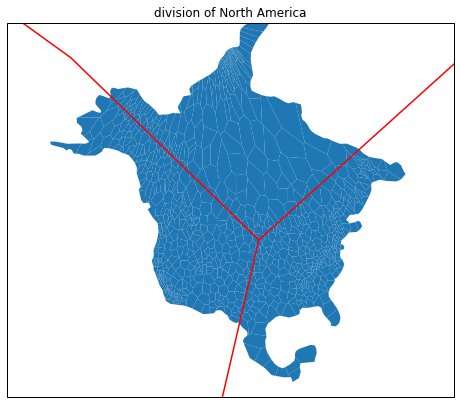

In [263]:
# plot pole and wedge subdivisions
wedge_1_lon_loc = 340  # local coords
wedge_1_lat_loc = 0  # local coords
wedge_2_lon_loc = 120  # local coords
wedge_2_lat_loc = 0  # local coords
wedge_3_lon_loc = 212  # local coords
wedge_3_lat_loc = 0  # local coords


wedge_1_lat_glo, wedge_1_lon_glo = geo_convert(wedge_1_lat_loc, wedge_1_lon_loc, R)
wedge_2_lat_glo, wedge_2_lon_glo = geo_convert(wedge_2_lat_loc, wedge_2_lon_loc, R)
wedge_3_lat_glo, wedge_3_lon_glo = geo_convert(wedge_3_lat_loc, wedge_3_lon_loc, R)

crs = ccrs.AzimuthalEquidistant(central_latitude=40, central_longitude=-110)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=crs)
columns_na_tmp = columns_na.to_crs(crs.proj4_init)
ax.add_geometries(columns_na_tmp['geometry'], crs=crs)
ax.set_extent([-150, -60, 10, 90], crs=ccrs.Geodetic())
plt.plot([pole_lon, wedge_1_lon_glo], [pole_lat, wedge_1_lat_glo], color='red',  transform=ccrs.Geodetic())
plt.plot([pole_lon, wedge_2_lon_glo], [pole_lat, wedge_2_lat_glo], color='red',  transform=ccrs.Geodetic())
plt.plot([pole_lon, wedge_3_lon_glo], [pole_lat, wedge_3_lat_glo], color='red',  transform=ccrs.Geodetic())
plt.title('division of North America')
plt.show()

In [264]:
# now separate units into each wedge
# wedge 1: between wedge 1 and wedge 2
# wedge 2: between wedge 2 and wedge 3
# wedge 3: between wedge 3 and wedge 1

# need columns centroids (aka unit locations)
columns_na_pts = columns_na.copy()
columns_na_pts['geometry'] = units_na.dissolve(by='col_id')['geometry']
# transform back to lat/lon
columns_na_pts = columns_na_pts.to_crs(ccrs.Geodetic().proj4_init)

# get column indices per wedge
# transform coords to filtering coord system
filt_lat = np.zeros(n_cols)
filt_lon = np.zeros(n_cols)
# get lat, lon of each column in filtering reference (i.e. rotated so that intersection of red lines plotted above is north pole)
for ii in tqdm_notebook(range(n_cols)):
    cur_lat = columns_na_pts.iloc[ii]['geometry'].y
    cur_lon = columns_na_pts.iloc[ii]['geometry'].x
    filt_lat[ii], filt_lon[ii] = geo_convert(cur_lat, cur_lon, R.T)
    
# force longitudes to positive values
filt_lon[filt_lon < 0] = filt_lon[filt_lon < 0] + 360

In [265]:
# array of wedge indices, one for each column
wedge_idx = np.zeros(n_cols)
# logical indices for wedge 1
idx_1 = (filt_lon > wedge_1_lon_loc) | (filt_lon < wedge_2_lon_loc)
wedge_idx[idx_1] = 1
# logical indices for wedge 2
idx_2 = (filt_lon > wedge_2_lon_loc) & (filt_lon < wedge_3_lon_loc)
wedge_idx[idx_2] = 2
# logical indices for wedge 3
idx_3 = (filt_lon > wedge_3_lon_loc) & (filt_lon < wedge_1_lon_loc)
wedge_idx[idx_3] = 3

/Users/adrianraph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


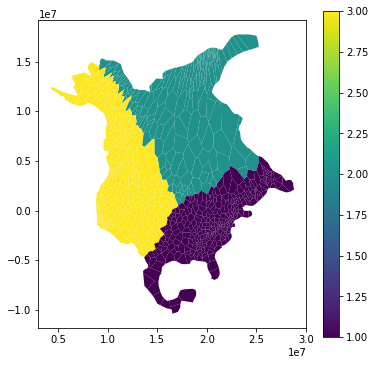

In [266]:
columns_na['wedge'] = wedge_idx

# show divided columns
columns_na.plot(column='wedge', legend=True, figsize=(6,6))

### Focused basin-scale subdivision

To do...(or not)

The naive partition above can be further subdivided into distinct basins rather than just Laurentian margins, for example along the lines of the schematic shown below from [Miall, A. D., & Blakey, R. C. (2019)](https://doi.org/10.1016/b978-0-444-63895-3.00001-2). 

<img src="figures/Miall2019_fig1.jpg" width=400px>



## Sedimentation by margin

### maximum and minimum thicknesses

Having subdivided North America into the three basic margins of Laurentia, I now just use the above code on the columns within each margin and aggregate by margin to create minimum and maximum sedimentation curves through time.

Running the following code block takes a little bit.

In [334]:
# create time bins
dt = 10
t = np.arange(0, 1000+dt, dt)
t_bins = np.diff(t)/2 + t[0:-1]
n_tbins = len(t)-1

# loop over bins
marg1 = pd.DataFrame(index=np.arange(n_tbins), columns=['max volume', 'min volume'])
marg2 = pd.DataFrame(index=np.arange(n_tbins), columns=['max volume', 'min volume'])
marg3 = pd.DataFrame(index=np.arange(n_tbins), columns=['max volume', 'min volume'])

for ii in tqdm_notebook(range(n_tbins)):
    cur_t1 = t[ii+1]
    cur_t2 = t[ii]
    # get current thicknesses (corrected)
    cur_thicks = seds_by_column_and_age_range(units_seds_na, t1=cur_t1, t2=cur_t2)
    # make into volumes (don't forget unit conversion from km^2 to m^2)
    cur_thicks['max volume'] = cur_thicks['max_thick'] * (1e6*columns_na['col_area'].astype(float))
    cur_thicks['min volume'] = cur_thicks['min_thick'] * (1e6*columns_na['col_area'].astype(float))
    # separate by basin
    cur_thicks['wedge'] = columns_na['wedge']
    # add up
    cur_vols = cur_thicks.groupby('wedge').sum()
    marg1.iloc[ii]['max volume'] = cur_vols.loc[1, 'max volume']
    marg1.iloc[ii]['min volume'] = cur_vols.loc[1, 'min volume']
    marg2.iloc[ii]['max volume'] = cur_vols.loc[2, 'max volume']
    marg2.iloc[ii]['min volume'] = cur_vols.loc[2, 'min volume']
    marg3.iloc[ii]['max volume'] = cur_vols.loc[3, 'max volume']
    marg3.iloc[ii]['min volume'] = cur_vols.loc[3, 'min volume']
    
# make sure are floats
marg1[:] = marg1[:].astype(float)
marg2[:] = marg2[:].astype(float)
marg3[:] = marg3[:].astype(float)

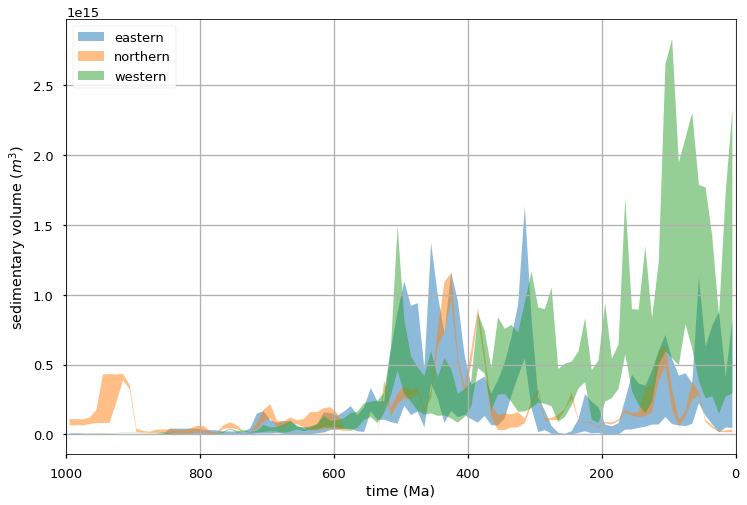

In [539]:
# plot up

fig = plt.figure(figsize=(12,8))

# eastern margin of laurentia
plt.fill_between(t_bins, 
                 marg1['min volume'].astype(float).values, 
                 marg1['max volume'].astype(float).values, 
                 label='eastern',
                 alpha=0.5)

# northern
plt.fill_between(t_bins, 
                 marg2['min volume'].astype(float).values, 
                 marg2['max volume'].astype(float).values, 
                 label='northern',
                 alpha=0.5)

# western
plt.fill_between(t_bins, 
                 marg3['min volume'].astype(float).values, 
                 marg3['max volume'].astype(float).values, 
                 label='western',
                 alpha=0.5)

plt.legend(loc='upper left')
plt.xlabel('time (Ma)')
plt.ylabel('sedimentary volume ($m^3$)')
# plt.yscale('log')
plt.xlim(1000, 0)
plt.grid()


### sediment presence

The following code block aggregates column-wise sediment presence (scaled by column area) to reproduce the approach taken by Peters and Husson in their utilization of Macrostrat data.

Assumes that the above code block has already been run.

In [537]:
# use same time bins from above

# total column areas (i.e. area of north america)
total_area = np.sum(columns_na['col_area'].astype(float))
columns_na.loc[:, 'fractional area'] = columns_na['col_area'].astype(float)/total_area
marg1['presence'] = 0
marg2['presence'] = 0
marg3['presence'] = 0

for ii in tqdm_notebook(range(n_tbins)):
    cur_t1 = t[ii+1]
    cur_t2 = t[ii]
    # get current thicknesses (corrected)
    sed_presence = seds_by_column_and_age_range(units_seds_na,
                                              t1=cur_t1, 
                                              t2=cur_t2, 
                                              method='presence')
    # scale by area
    sed_presence.loc[:, 'fractional area'] = columns_na['fractional area'] * \
                                              sed_presence['presence']
    # separate by basin
    sed_presence['wedge'] = columns_na['wedge']
    # add up
    presence_by_wedge = sed_presence.groupby('wedge').sum()
    marg1.loc[ii, 'presence'] = presence_by_wedge.loc[1, 'fractional area']
    marg2.loc[ii, 'presence'] = presence_by_wedge.loc[2, 'fractional area']
    marg3.loc[ii, 'presence'] = presence_by_wedge.loc[3, 'fractional area']
    
# make sure are floats
marg1[:] = marg1[:].astype(float)
marg2[:] = marg2[:].astype(float)
marg3[:] = marg3[:].astype(float)

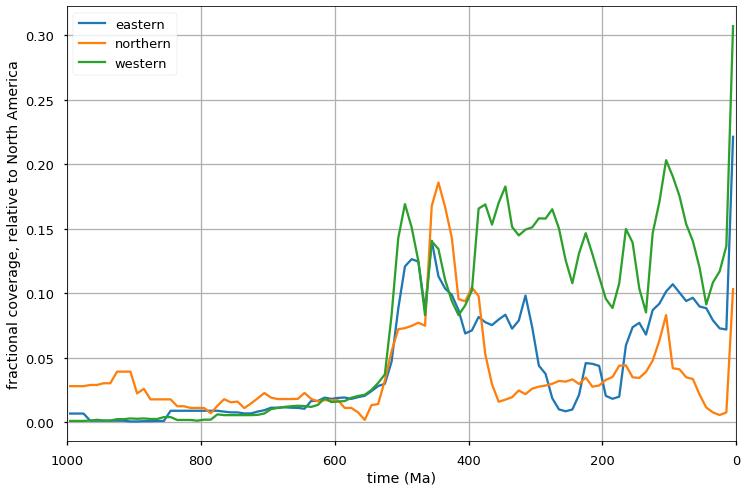

In [538]:
# plot up

fig = plt.figure(figsize=(12,8))

# eastern margin of laurentia
plt.plot(t_bins, marg1['presence'], 
                 label='eastern')

# northern
plt.plot(t_bins, marg2['presence'], 
                 label='northern')

# western
plt.plot(t_bins, marg3['presence'], 
                 label='western')

plt.legend(loc='upper left')
plt.xlabel('time (Ma)')
plt.ylabel('fractional coverage, relative to North America')
# plt.yscale('log')
plt.xlim(1000, 0)
plt.grid()


### Moving window Monte Carlo cross-correlation matrices

This section assumes that the min-max volume envelope is approximately interpretable as a 95% confidence interval, meaning that we can sample from the envelope to generate ensembles of possible sediment accumulation time histories.

For each time history, we can compute cross-correlations of the accumulated sediments by margin and at the end then construct a probabilistic inter-margin cross-correlation matrix through time. These correlations would reflect the extent to which basins accumulate sediment similarly and could in turn be an indicator for global sedimentary shifts attributable to, for instance, eustatic changes. 

The Monte Carlo draws should reflect that within the range of minimum and maximum thicknesses we actually don't have a great sense of the true value, i.e. the maximum likelihood value is not obviously in the middle of the range. Furthermore, there is a possibility that the true value extends beyond the limits we've computed, and we don't have a great idea if it's more likely to exceed the maximum volume or deceed (we really need this word) the minimum volume, except that the minimum volume can never be less than zero.

For these reasons, I will use a truncated generalized normal distribution with $\beta = 10$ to model the possible volumes, since this distribution approximates a uniform within the 2-$\sigma$ range surrounding a central value, but it also has a tail that extends beyond the central plateau of probability density.

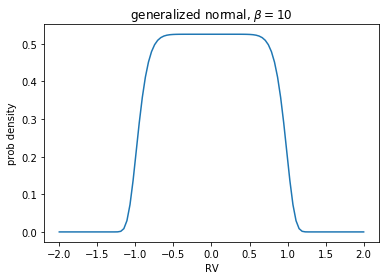

In [286]:
from scipy import stats

x = np.linspace(-2, 2, 100)
beta = 10

plt.figure(figsize=(6,4))
plt.plot(x, stats.gennorm.pdf(x, beta, loc=0, scale=1))
plt.xlabel('RV')
plt.ylabel('prob density')
plt.title('generalized normal, $\\beta=$%d' % beta)
plt.show()

Given this probability density, we can proceed as follows for each time bin of sediment accumulation along each margin:

1. define a mean as the value between the maximum and minimum volume accumulation estimates
2. define the scale as the distance from the central value to the max/min values
3. for each time step, sample many thousand values to create several simulated sediment accumulation histories
    - *remember to keep volumes non-negative*
4. for each time history and within bins of time steps compute inter-margin cross correlations so that we end up with a time varying suite of 3x3 cross-correlation matrices
5. compute statistics on the cross correlation matrices and plot their entries along the time bins within which they were generated

In [337]:
# implement above approach

# 1 & 2
scale = pd.DataFrame()
scale['margin 1'] = (marg1['max volume'] - marg1['min volume'])/2
scale['margin 2'] = (marg2['max volume'] - marg2['min volume'])/2
scale['margin 3'] = (marg3['max volume'] - marg3['min volume'])/2

loc = pd.DataFrame()
loc['margin 1'] = scale['margin 1'] + marg1['min volume']
loc['margin 2'] = scale['margin 2'] + marg2['min volume']
loc['margin 3'] = scale['margin 3'] + marg3['min volume']

# 3
n_sim = 10000
# monte carlo'd sediment volumne accumulations
sed_mc = np.zeros((n_sim, len(t_bins), 3))
for mm in tqdm_notebook(range(3)):
    sed_mc[:, :, mm] = stats.gennorm.rvs(n_sim, 
                                      loc=loc.iloc[:,mm].values,
                                      scale=scale.iloc[:,mm].values,
                                      size=[n_sim, len(t_bins)])
sed_mc[sed_mc[:] < 0] = 0

In [ ]:
# 4 cross-correlations within moving window time bins
corr_win = 80    # correlation window width in my
corr_ovlap = dt  # correlation window overlap (make it bin spacing from above)

# moving window start and stop times
t_corr_start = t[0]
t_corr_end = t_corr_start + corr_win

t_corr_starts = []
t_corr_ends = []

# list of [3 x 3 x n_sim] correlation coefficient arrays, one for each correlation time bin
corrs = []
while t_corr_end < t[-1]:
    # save windows
    t_corr_starts.append(t_corr_start)
    t_corr_ends.append(t_corr_end)
    
    # correlation window logical indices
    idx = (t_bins > t_corr_start) & (t_bins < t_corr_end) 
    
    # initialize correlation variable
    cur_C = np.zeros((3, 3, n_sim))
    # iterate over each simulation
    for ii in tqdm_notebook(range(n_sim)):
        cur_C[:, :, ii] = np.corrcoef(sed_mc[ii, idx, :], rowvar=False)
    
    # save correlations
    corrs.append(cur_C)
    
    # increment window boundaries
    t_corr_start += corr_ovlap
    t_corr_end += corr_ovlap

In [380]:
# 5
corrs_mean = np.asarray([np.mean(x, axis=2) for x in corrs])
corrs_std = np.asarray([np.std(x, axis=2) for x in corrs])

t_bins_corr = (np.asarray(t_corr_ends) - np.asarray(t_corr_starts))/2 + np.asarray(t_corr_starts)

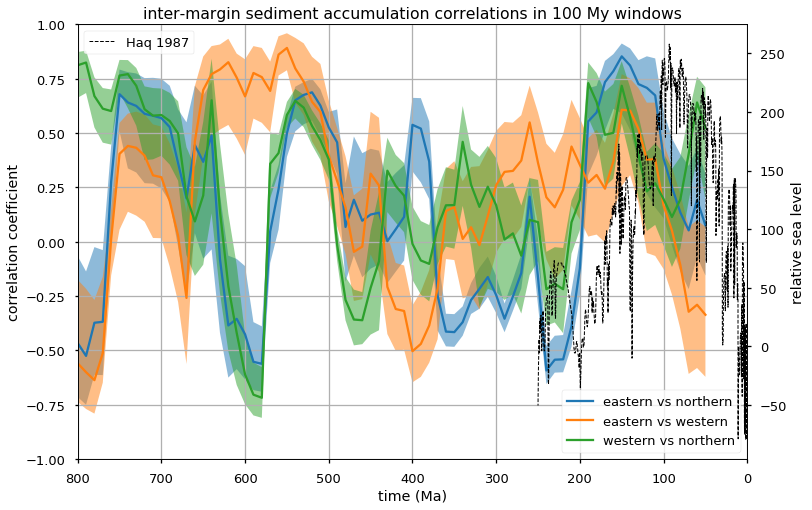

In [482]:
# plot correlation coefficients with spread through time

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(12, 8))
ax1 = plt.axes()
ax2 = ax1.twinx()

# eastern with northern
# ax1.fill_between(t_bins_corr, 
#                 corrs_mean[:, 0, 1] - 2*corrs_std[:, 0, 1],
#                 corrs_mean[:, 0, 1] + 2*corrs_std[:, 0, 1],
#                 alpha=0.5)
# ax1.boxplot([x[0, 1, :] for x in corrs], 
#              positions=t_bins_corr,
#             showfliers=False,
#            showcaps=False,
#            whis=[5, 95],
#            manage_ticks=False,
#            widths=1.5,
#            boxprops={'color':colors[0]},
#            whiskerprops={'color':colors[0]})
ax1.fill_between(t_bins_corr, 
                np.percentile(np.asarray([x[0, 1, :] for x in corrs]), 5, axis=1),
                np.percentile(np.asarray([x[0, 1, :] for x in corrs]), 95, axis=1),
                alpha=0.5)
ax1.plot(t_bins_corr, corrs_mean[:, 0, 1], label='eastern vs northern')

# eastern with western
ax1.fill_between(t_bins_corr, 
                np.percentile(np.asarray([x[0, 2, :] for x in corrs]), 5, axis=1),
                np.percentile(np.asarray([x[0, 2, :] for x in corrs]), 95, axis=1),
                alpha=0.5)
ax1.plot(t_bins_corr, corrs_mean[:, 0, 2], label='eastern vs western')

# western with northern
ax1.fill_between(t_bins_corr, 
                np.percentile(np.asarray([x[1, 2, :] for x in corrs]), 5, axis=1),
                np.percentile(np.asarray([x[1, 2, :] for x in corrs]), 95, axis=1),
                alpha=0.5)
ax1.plot(t_bins_corr, corrs_mean[:, 1, 2], label='western vs northern')

# plot sealevels
ax2.plot(sea_level.iloc[:,14], sea_level.iloc[:,13], 'k--', linewidth=1, label='Haq 1987')
# ax2.plot(sea_level.iloc[:,4], sea_level.iloc[:,5], 'k-.', linewidth=1, label='Kominz 2008')

# label
ax1.legend()
ax2.legend()
ax1.set_xlabel('time (Ma)')
ax1.set_ylabel('correlation coefficient')
ax2.set_ylabel('relative sea level')
plt.title('inter-margin sediment accumulation correlations in %d My windows' % corr_win)

ax1.set_ylim([-1, 1])
ax1.set_xlim(800, 0)

# ax1.set_ylim([-1, 1])
ax2.set_xlim(800, 0)

ax1.grid()

### Column-wise moving window PCA